In [1]:
#%matplotlib inline
#%pip install pandas_summary
#%pip install waterfallcharts
#%pip install treeinterpreter
#%pip install fastai

In [1]:
# !pip install pandas_summary
# !pip install waterfallcharts
# !pip install treeinterpreter
# !pip install time

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import waterfall_chart

from fastai.imports import *
from fastai.tabular import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_recall_curve, confusion_matrix, recall_score, precision_score
from sklearn.model_selection import cross_val_score
from matplotlib.ticker import FuncFormatter


# Data Processing

In [2]:
import pandas as pd

# Load the dataset
df  = pd.read_csv('adult.csv')  # Replace with the path to your dataset
df.head()


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [3]:
print ("Records and variables: ", df.shape)
print ("Column names: ", df.columns.to_list())

Records and variables:  (32561, 15)
Column names:  ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'income']


In [4]:
df.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [5]:
# Display categorical variables
categorical_vars = df.select_dtypes(include='object').columns
print('Categorical Variables:', categorical_vars.tolist())

Categorical Variables: ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country', 'income']


In [ ]:
categorical_vars = [
    'workclass', 'education', 'marital.status', 'occupation',
    'relationship', 'race', 'sex', 'native.country'
]

# Replace missing values represented by ' ?' with NaN
df[categorical_vars] = df[categorical_vars].replace(' ?', pd.NA)

# Drop rows with missing values
df.dropna(inplace=True)

# One-hot encode categorical variables
data_encoded = pd.get_dummies(df, columns=categorical_vars)


# Convert target variable 'income' to binary
# 1 if the income is >50K
# 0 if the income is <=50K
data_encoded['income'] = data_encoded['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

# Separate features and target
X = data_encoded.drop('income', axis=1)
y = data_encoded['income']

print('Features shape:', X.shape)
print('Target shape:', y.shape)


Features shape: (32561, 108)
Target shape: (32561,)


In [10]:
data_encoded.head()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,income,workclass_?,workclass_Federal-gov,workclass_Local-gov,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
0,90,77053,9,0,4356,40,0,True,False,False,...,False,False,False,False,False,False,False,True,False,False
1,82,132870,9,0,4356,18,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,66,186061,10,0,4356,40,0,True,False,False,...,False,False,False,False,False,False,False,True,False,False
3,54,140359,4,0,3900,40,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,41,264663,10,0,3900,40,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False


Show class distribution of target variable

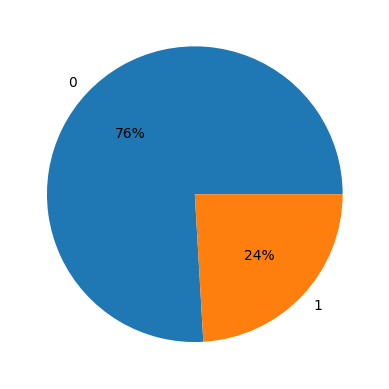

In [11]:
unique, counts = np.unique(data_encoded["income"], return_counts=True)
plt.pie(counts, labels=unique, autopct='%.0f%%');

There's more people, 76%, with an income lower than 50k.

In [13]:
data_encoded.shape

(32561, 109)

There are 569 rows and 31 columns. 

#### Check for nulls

In [14]:
# check for missing values
data_encoded.columns[data_encoded.isnull().any()]

Index([], dtype='object')

No missing values

# Random forest first try

#### Train-Test Split

In [15]:
#split data into train and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_encoded.iloc[:,data_encoded.columns != 'income'],
                                                    data_encoded['income'],
                                                    test_size=0.25, 
                                                    random_state=100)

In [16]:
x_train.shape, y_train.shape

((24420, 108), (24420,))

In [17]:
x_test.shape, y_test.shape

((8141, 108), (8141,))

We create the fist RF classifier only to find later optimal parameters <BR>(this would be just Bagging)

In [18]:
baseRF = RandomForestClassifier(n_estimators = 200,  #The number of trees in the forest
                               random_state = 0,
                               n_jobs = -1, # The number of jobs to run in parallel (-1 means all processors, 1 no parallelism)
                               oob_score = True) # Whether to use out-of-bag samples to estimate the generalization score (increases time)
# oob are the samples not chosen on the boostrapping process

# other parameters:
# criterion{"gini", "entropy", "log_loss"}, default="gini"
# max_depth: int, default=None
# min_samples_leaf: int or float, default=1 - The minimum number of samples required to be at a leaf node
# min_samples_split: int or float, default=2 - The minimum number of samples required to split an internal node:
# max_features{"sqrt", "log2", None}, int or float, default="sqrt" - The number of features to consider when looking for the best split

Now we are searching for the set of parameters that give the best performance, then we will need to use them in a RF Classifier

In [19]:
param_grid = {
    'min_samples_leaf' :[1,3,5], 
    'max_features' : [10,15,20,25,30],
    'criterion' : ['gini','entropy'] #,'log_loss']
}

The following execution will take some time (1 to 2 minutes). Ignore the warnings

In [20]:
import time 
start_time = time.time()

from sklearn.model_selection import GridSearchCV
cvRF = GridSearchCV(estimator=baseRF, param_grid=param_grid, cv=3, scoring='roc_auc') 
#cv is the number of cross validation iterations to be performed
cvRF.fit(x_train,y_train)

print ("Completed in --- %s seconds ---" % (time.time() - start_time))

Completed in --- 322.3716707229614 seconds ---


In [21]:
# shows the best combination of criteria found
cvRF.best_params_

{'criterion': 'entropy', 'max_features': 20, 'min_samples_leaf': 5}

In [22]:
# shows the best score (of the scoring function we selected, here ROC AUC) from TRAINING DATASET
cvRF.best_score_

np.float64(0.9167369741132975)

Our best parameters are {'criterion': 'entropy', 'max_features': 15, 'min_samples_leaf': 5}.<BR>
Our average AUC score of all folds for training dataset is 0.989.

#### Now we train the model with the best parameters and using Random Forest instead of simple Bagging.
##### The difference is the parameter "max_features"

In [23]:
model = RandomForestClassifier(n_estimators = 200, 
                               random_state = 0,
                               max_features = 20, #this parameter makes the difference between simple Bagging and Random Forests
                               n_jobs = -1,
                               oob_score = True,
                               criterion = 'entropy',
                               min_samples_leaf = 5)
model.fit(x_train,y_train)

# predictions
y_pred_test = model.predict(x_test)

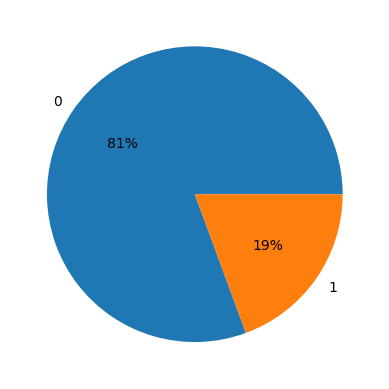

In [24]:
unique, counts = np.unique(y_pred_test, return_counts=True)
plt.pie(counts, labels=unique, autopct='%.0f%%');

In [25]:
print("OOB score: {:.3f}".format(model.oob_score_))
# The OOB score is an estimate of the generalization error of the model, 
# calculated with the data not used to train it.

OOB score: 0.865


An OOB score of 0.865 indicates that your Random Forest model has an estimated accuracy of 86.5% on unseen data. This is generally considered a good score, suggesting that the model performs well and generalizes effectively to new, untrained samples. However, it's advisable to compare this score with other evaluation metrics and consider the context of your specific problem to determine if it meets your performance criteria.

 This attribute stores the OOB score computed during the training of the Random Forest model. It reflects the accuracy on out-of-bag samples, which are observations not included in the bootstrap sample for each tree.

- model.oob_score_: This attribute stores the OOB score computed during the training of the Random Forest model. It reflects the accuracy on out-of-bag samples, which are observations not included in the bootstrap sample for each tree.
- {:.3f}: This format specification ensures the OOB score is displayed with three decimal places.
- "OOB score: {:.3f}".format(model.oob_score_): The format method inserts the OOB score into the string, applying the specified formatting.

The accompanying comment clarifies that the OOB score provides an estimate of how well the model generalizes to new, unseen data based on the out-of-bag samples.

In [21]:
# attributes of the model object (for your reference)
# print(dir(model))

In [33]:
class_labels = model.classes_
print(class_labels)

[0 1]


Now we are applying our model to the TEST dataset

In [38]:
pred_prob = model.predict_proba(x_test) #probability of being in both groups
prob_bigger = [p[1] for p in pred_prob] #probability of being in >50K
auc = roc_auc_score(y_test, prob_bigger)

# 1 if the income is >50K
# 0 if the income is <=50K

# https://scikit-learn.org/stable/modules/model_evaluation.html

In [36]:
print("AUC score: {:.3f}".format(auc))

AUC score: 0.920


Our auc score is very good for this model. <BR>
Let's compare accuracy and show ROC curve

In [41]:
# AUC Calculations - false positive rates, true positive rates and thresholds
fpr, tpr, thresholds = metrics.roc_curve(y_test, prob_bigger, pos_label=1)

train_acc = round(model.score(x_train,y_train) * 100,2) #Train Accuracy score
test_acc = round(model.score(x_test,y_test) * 100,2) #Test Accuracy score
print("Train Accuracy score: ", train_acc, "%")
print("Test Accuracy score: ", test_acc, "%")

Train Accuracy score:  89.42 %
Test Accuracy score:  86.46 %


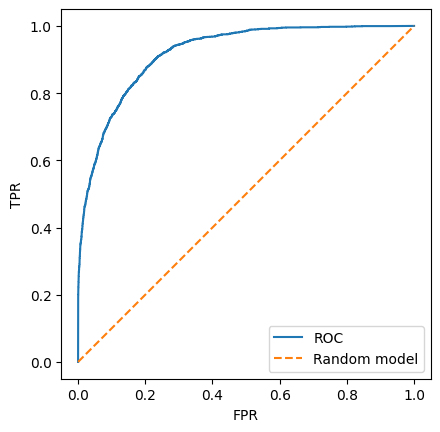

In [42]:
# ROC curve

fig, ax = plt.subplots(1, 1)
ax.plot(fpr, tpr, label="ROC")
ax.plot([0, 1], [0, 1],linestyle='--', label="Random model") 
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_box_aspect(1)
ax.legend()
plt.show()

And now the Precision and Recall chart

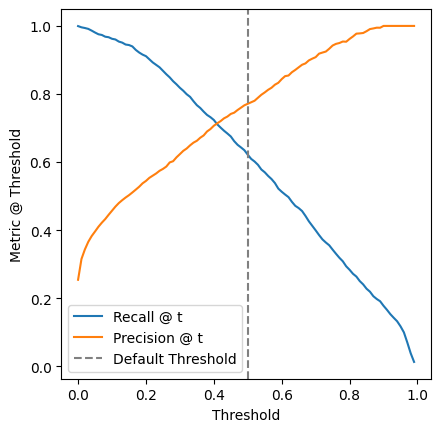

In [43]:
# We can compare Recall and Precision

prob_pred = model.predict_proba(x_test)[:, 1]
thresholds = np.arange(0.0, 1.0, step=0.01)
recall_scores = [metrics.recall_score(y_test, prob_pred > t) for t in thresholds]
precis_scores = [metrics.precision_score(y_test, prob_pred > t) for t in thresholds]
fig, ax = plt.subplots(1, 1)
ax.plot(thresholds, recall_scores, label="Recall @ t")
ax.plot(thresholds, precis_scores, label="Precision @ t")
ax.axvline(0.5, c="gray", linestyle="--", label="Default Threshold")
ax.set_xlabel("Threshold")
ax.set_ylabel("Metric @ Threshold")
ax.set_box_aspect(1)
ax.legend()
plt.show()

### Tree interpreter: calculate the contribution of each feature to the tree prediction.
##### We will use it first with scikit and then with an additional library

In [44]:
dir(model)
model.feature_names_in_

array(['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss',
       'hours.per.week', 'workclass_?', 'workclass_Federal-gov',
       'workclass_Local-gov', 'workclass_Never-worked',
       'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'education_10th', 'education_11th',
       'education_12th', 'education_1st-4th', 'education_5th-6th',
       'education_7th-8th', 'education_9th', 'education_Assoc-acdm',
       'education_Assoc-voc', 'education_Bachelors',
       'education_Doctorate', 'education_HS-grad', 'education_Masters',
       'education_Preschool', 'education_Prof-school',
       'education_Some-college', 'marital.status_Divorced',
       'marital.status_Married-AF-spouse',
       'marital.status_Married-civ-spouse',
       'marital.status_Married-spouse-absent',
       'marital.status_Never-married', 'marital.status_Separated',
       'marital.status_Widowed', 'occupation_?'

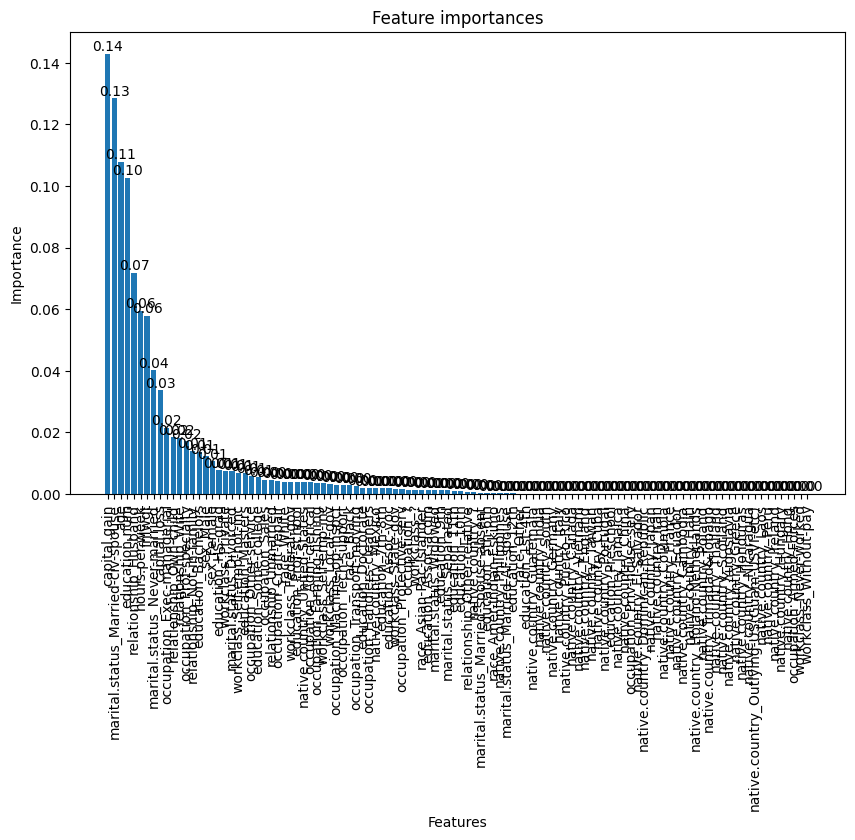

In [45]:
importances = model.feature_importances_

indexes = np.argsort(importances)[::-1]
sorted_imp = importances[indexes]

plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(importances)), importances[indexes], align='center')
plt.xticks(range(len(importances)), np.array(model.feature_names_in_)[indexes], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature importances")
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{sorted_imp[i]:.2f}', ha='center', va='bottom')
plt.show()

In [46]:
# Show the top 10 features with most importance and print the importance value
for i in range(10):
    print(f"{model.feature_names_in_[indexes[i]]}: {sorted_imp[i]}")

capital.gain: 0.14287248170669867
marital.status_Married-civ-spouse: 0.12849606045471934
age: 0.10782649320042528
education.num: 0.1026766163373341
relationship_Husband: 0.07174933106060069
hours.per.week: 0.05954548443220412
fnlwgt: 0.05779372364709524
marital.status_Never-married: 0.040188102651767414
capital.loss: 0.03365770120488793
occupation_Exec-managerial: 0.02156606939227086


##### Now with an additional library that shows individual importance directions and decomposes the model prediction into three parts: 
1. Bias: The overall average prediction of the model without taking individual features into account.
2. Contributions: The specific influence of each feature on the prediction value for the instance in question.
3. Final Prediction: This is the final result for the particular observation, obtained by summing the bias and all feature contributions.

In [47]:
from treeinterpreter import treeinterpreter as ti

/home/codespace/.python/current/lib/python3.12/site-packages/waterfall_chart.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y_height[loop] + row['amount']
/home/codespace/.python/current/lib/python3.12/site-packages/waterfall_chart.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y_height[loop]


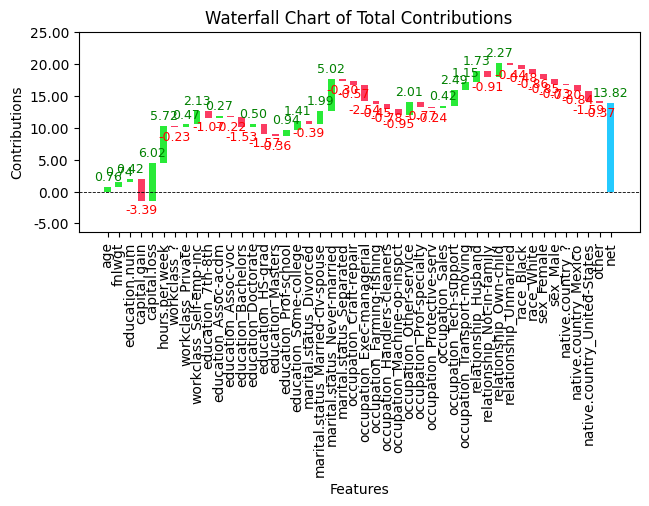

In [48]:
predictions, biases, contributions = ti.predict(model, x_test.values)

# Convert contributions into a dataframe
contributions_df = pd.DataFrame(contributions[:, :, 0], columns=x_test.columns)

# Suming contributions from every row
total_contributions = contributions_df.sum(axis=0)

# Show chart (now displaying features with contribution less than 0.03)
waterfall_chart.plot(x_test.columns, total_contributions, rotation_value=90, threshold=0.03, formatting='{:,.2f}')
plt.title('Waterfall Chart of Total Contributions')
plt.xlabel('Features')
plt.ylabel('Contributions')
plt.show()

### What is the optimum number of trees?

Overfitting does not depend on the number of trees, but we don´t want to run with more trees than necessary

In [49]:
train_scores = []
cv_scores    = []

estimator_range = range(5, 105, 5) #from 5 trees to 100, step 5

for n_estimators in estimator_range:
    model = RandomForestClassifier(
                n_estimators = n_estimators,
                max_features = 15, # the previous optimum
                oob_score    = False,
                n_jobs       = -1, 
                random_state = 123
             )
    
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    acc=accuracy_score(y_test, predictions)
    print("% Accuracy of test dataset for {} trees is {:.3f}".format(n_estimators, acc))
    train_scores.append(acc) # storing accuracy from each iteration

    # and we also store the accuracy mean obtained from running a 5-fold validation
    cvscores = cross_val_score(
                estimator = model,
                X         = x_train,
                y         = y_train,
                scoring   = 'accuracy',
                cv        = 5
             )
    cv_scores.append(cvscores.mean()) 

% Accuracy of test dataset for 5 trees is 0.838
% Accuracy of test dataset for 10 trees is 0.846
% Accuracy of test dataset for 15 trees is 0.848
% Accuracy of test dataset for 20 trees is 0.850
% Accuracy of test dataset for 25 trees is 0.850
% Accuracy of test dataset for 30 trees is 0.854
% Accuracy of test dataset for 35 trees is 0.853
% Accuracy of test dataset for 40 trees is 0.854
% Accuracy of test dataset for 45 trees is 0.853
% Accuracy of test dataset for 50 trees is 0.854
% Accuracy of test dataset for 55 trees is 0.853
% Accuracy of test dataset for 60 trees is 0.853
% Accuracy of test dataset for 65 trees is 0.853
% Accuracy of test dataset for 70 trees is 0.853
% Accuracy of test dataset for 75 trees is 0.854
% Accuracy of test dataset for 80 trees is 0.854
% Accuracy of test dataset for 85 trees is 0.854
% Accuracy of test dataset for 90 trees is 0.855
% Accuracy of test dataset for 95 trees is 0.855
% Accuracy of test dataset for 100 trees is 0.855


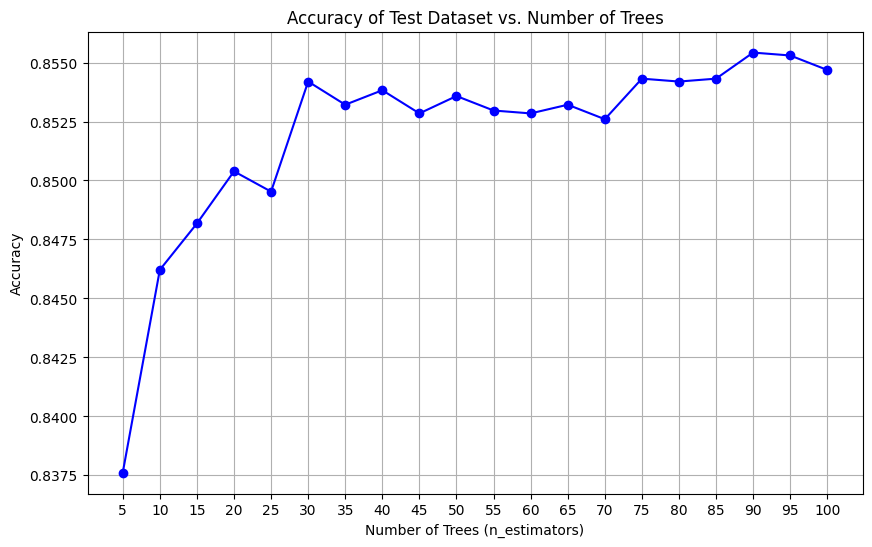

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(estimator_range, train_scores, marker='o', linestyle='-', color='b')
plt.title('Accuracy of Test Dataset vs. Number of Trees')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.xticks(estimator_range)  # Para mostrar todos los valores en el eje x
plt.grid()
plt.show()

Optimum number of trees: 60


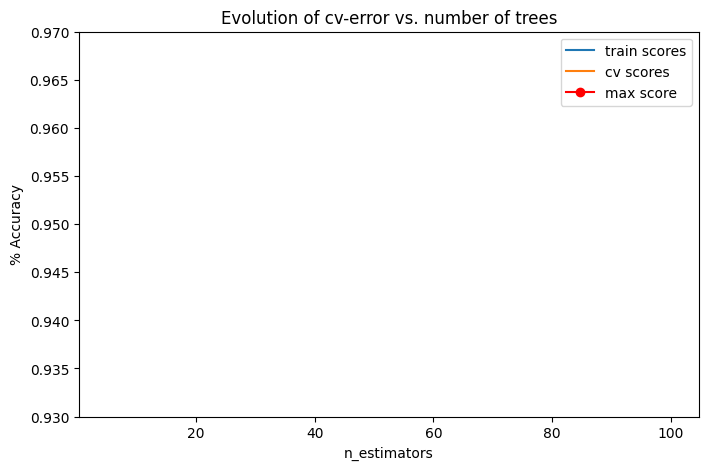

In [52]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmax(cv_scores)], max(cv_scores),
        marker='o', color = "red", label="max score")
ax.set_ylim(0.93, 0.97)
ax.set_ylabel("% Accuracy")
ax.set_xlabel("n_estimators")
ax.set_title("Evolution of cv-error vs. number of trees")
plt.legend();
print(f"Optimum number of trees: {estimator_range[np.argmax(cv_scores)]}")